![Kickstarer](./images/kickstarter.png)

---
Imports
---

In [ ]:
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.preprocessing import MinMaxScaler


import json
from sklearn.dummy import DummyClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split



import warnings
warnings.filterwarnings('ignore')

RSEED = 42069

In [ ]:
# Import the .csv files and concat them into one dataframe
original_dataframe = pd.concat(map(pd.read_csv, glob.glob('data/data-2/*.csv')))
# Reset the indices
original_dataframe.reset_index(drop=True, inplace=True)

In [ ]:
# Set a working dataframe, so that we don't have to wait 10s it to import again if we want to start fresh
df = original_dataframe

---
EDA - Part 1
---

In [ ]:
df.info()

In [ ]:
df.isnull().sum()

In [ ]:
# Only a very limited amount of suspended projects (drop), canceled projects will be treated as though they failed
df['state'].value_counts()

In [ ]:
# Check for duplicate projects and store them in a table
dups = df.groupby(df.id.tolist()).size().reset_index().rename(columns={0:'count'})
# Sum the final col of that table, and subtract the number of culprits:
dups['count'].sum() - dups.shape[0]

---
Data Cleaning
---

In [ ]:
# Drop features which will not be needed for further analysis
dropped_features = ['blurb', 'currency_symbol', 'backers_count', 'is_backing', 'permissions', 'is_starred', 'source_url',
                    'slug', 'name', 'static_usd_rate', 'profile', 'friends', 'spotlight', 'is_starrable', 'photo', 'pledged', 'usd_type',
                    'fx_rate', 'location', 'creator', 'currency_trailing_code','current_currency', 'created_at', 'urls', 'disable_communication', 'usd_pledged' ]
df = df.drop(dropped_features, axis=1)

In [ ]:
# Built array which contains live projects for later use 
array_live = ['live']
live_projects = df.loc[df['state'].isin(array_live)]

# Filter and concat. for target variable
array_notlive = ['successful', 'failed', 'canceled']
df = df.loc[df['state'].isin(array_notlive)]
df.replace('canceled','failed', inplace=True)

In [ ]:
# Replace successful and failed entries
df.replace(['successful','failed'],[1,0], inplace=True)

In [ ]:
# Sort dataframe by 'date_changed_at' so that we will keep the entry that was most recently updated
df.sort_values('state_changed_at')
# Remove duplicates
duplicates = df.duplicated(subset='id', keep='last')
df = df[~duplicates]

---
Feature Engineering
---

In [ ]:
df['category'] = df['category'].apply(lambda x: json.loads(x)['slug'])

In [ ]:
df['category'] = df['category'].apply(lambda x: x.split('/',)[0])

In [ ]:
# Generate new column with readable timeformat
df['launched_at_new'] = pd.to_datetime(df['launched_at'], unit='s')
df['deadline_new'] = pd.to_datetime(df['deadline'], unit='s')
df['state_changed_at_new'] = pd.to_datetime(df['state_changed_at'], unit='s')

In [ ]:
# Create new feature 'duration' that displays wheather the project timespan was more or less than 30 days
df = df.eval('duration = deadline - launched_at')
df['duration'] = ['over' if x > 2592000 else 'under' for x in df['duration']]

In [ ]:
# Add new column 'time' that displays the time from project launch to project end
df.eval('time = state_changed_at_new - launched_at_new', inplace=True)
# Convert to days
df['time'] = df['time'].apply(lambda x: pd.Timedelta(x).days)

In [ ]:
# Change dates to weekend(1) or weekday(0)
def change_time(dataframe, column_list):
    for column in column_list:
        dataframe[column] = [1 if x >= 6 else 0 for x in pd.to_datetime(dataframe[column], unit='s').dt.weekday]
    return dataframe

In [ ]:
times_lst = ['launched_at', 'deadline', 'state_changed_at']
change_time(df, times_lst)

---
EDA - Part 2
---

##### Plots

In [ ]:
# Which data needs to be plotted categorical and which numerical
categorical = ['country','currency', 'staff_pick', 'category','duration']
numerical = ['usd_pledged', 'goal', 'converted_pledged_amount']

In [ ]:
def bar_plot(df, column):
    """Generates barplots of categorical data

    Args:
        df (pd dataframe): Dataframe
        column (object): list of names of columns which should be plotted
    """
    # get feature
    for i in column:
        varValue = df[i].value_counts()

        plt.figure(figsize = (12,3))
        plt.bar(varValue.index, varValue, color = '#87c442', edgecolor = 'black')
        plt.xticks(varValue.index, varValue.index.values)
        plt.ylabel("Frequency")
        plt.title(i.capitalize())
        plt.xticks(rotation = 90)
        plt.show()

##### Categorical Data

In [ ]:
bar_plot(df, categorical)

##### Numerical Data

In [ ]:
# Outlier analysis
# We have some values in goal which are unrealistically high
# cutoff at 100000, we are focusing on small to average kickstarter projects
df = df.query('goal < 100000')

In [ ]:
plt.figure(figsize = (12,5))
plt.hist(df['goal'], bins = None, facecolor = '#87c442', edgecolor = 'black');
#range = [0.0,200000]

##### Misc

In [ ]:
# Drop id (not needed anymore) and converted pledged amount
df.drop('id', axis = 1, inplace = True)
df.drop('converted_pledged_amount', axis = 1, inplace = True)

#### One-hot encoding

In [ ]:
# One hot encode all categorical data (country, currency, staff_pick, categories, disable_communication, duration) boolean values might 
# Replace True False with strings, otherwise one-hot encoding doesnt work
df['staff_pick'].replace([True,False],['t','f'], inplace=True)


one_hot_featurelist = ['country', 'currency', 'staff_pick', 'category', 'duration']
one_hot = pd.get_dummies(df[one_hot_featurelist])
df.drop(one_hot_featurelist, axis = 1, inplace=True)
df = df.join(one_hot)

#### Scalerize

In [ ]:
def scale_columns(df, column):
    """Function that scales the data with a min_max scaler

    Args:
        df (dataframe): Dataframe
        column (object): Name or list of names including the columns which should be normalized

    Returns:
        Dataframe object: Returns the dataframe including the normalized columns
    """
    scaler = MinMaxScaler()
    for i in column:
        scaler.fit(df[[i]])
        df[i] = scaler.transform(df[[i]])
    
    return df

In [ ]:
# Standardize numerical data
numerical = ['goal']
df = scale_columns(df, numerical)

#### Dummy Classifier and Baseline Model

In [ ]:
# Drop features which will not be needed for further analysis
dropped_features = ['launched_at_new','deadline_new','state_changed_at_new']
df = df.drop(dropped_features, axis=1)

In [ ]:
df.head()

In [ ]:
# Set x and y
X = df.drop('state', axis = 1)
y = df['state']

In [ ]:
dummy_1 = DummyClassifier(strategy='stratified', random_state=RSEED, constant=None)
dummy_1.fit(X,y)

dummy_2 = DummyClassifier(strategy='most_frequent', random_state=RSEED, constant=None)
dummy_2.fit(X,y)

y_pred_1 = dummy_1.predict(X)
y_pred_2 = dummy_2.predict(X)

In [ ]:
f1_score(y, y_pred_1)
f1_score(y, y_pred_2)


In [ ]:
confusion_matrix(y, y_pred_1)

#### Model

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size= 0.3, random_state=RSEED)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

In [60]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, cross_val_score
from xgboost import XGBClassifier
import time

models = list()

#here is the list of the models we'll try 
models.append(LogisticRegression())
models.append(DecisionTreeClassifier())
models.append(RandomForestClassifier())
# models.append(SVC()) not good for large datasets
models.append(GradientBoostingClassifier())
models.append(AdaBoostClassifier(DecisionTreeClassifier(),learning_rate=0.1))
models.append(KNeighborsClassifier())
models.append(XGBClassifier())

In [61]:
kfold = StratifiedKFold(n_splits=10)

go: LogisticRegression()


/Users/maxh/neuerfische/Kickstarter_Challenge/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/maxh/neuerfische/Kickstarter_Challenge/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

end: LogisticRegression()
go: DecisionTreeClassifier()
end: DecisionTreeClassifier()
go: RandomForestClassifier()
end: RandomForestClassifier()
go: GradientBoostingClassifier()
end: GradientBoostingClassifier()
go: AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), learning_rate=0.1)
end: AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), learning_rate=0.1)
go: KNeighborsClassifier()
end: KNeighborsClassifier()
go: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monot

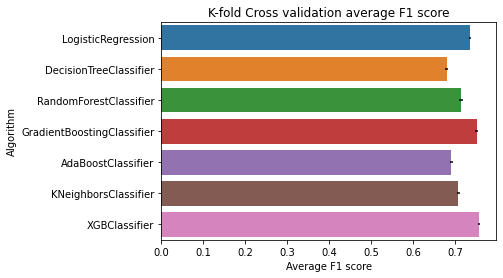

In [62]:
cv_results = []
cv_names = []
cv_times = []

for model in models :
    start_time = time.time()
    print('go:', model)
    cv_results.append(cross_val_score(model, X_train, y = y_train, scoring = "f1", cv = kfold, n_jobs=-1, verbose=1))
    cv_names.append(model.__class__.__name__)
    end_time = time.time()
    total_time = round(end_time - start_time ,2)
    cv_times.append(total_time)
    print('end:', model)

cv_means = []
cv_std = []

for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())
    

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":cv_names, "Time needed for training":cv_times})

g = sns.barplot("CrossValMeans","Algorithm",data = cv_res,orient = "h",**{'xerr':cv_std})
g.set_xlabel("Average F1 score")
g = g.set_title("K-fold Cross validation average F1 score")

In [63]:
cv_res['criterion'] = cv_res.CrossValMeans - cv_res.CrossValerrors/2

In [64]:
cv_res.sort_values(by='criterion', ascending=False)


,CrossValMeans,CrossValerrors,Algorithm,Time needed for training,criterion
6,0.757857,0.002802,XGBClassifier,70.042742,0.756456
3,0.752125,0.003022,GradientBoostingClassifier,33.995984,0.750615
0,0.736655,0.002584,LogisticRegression,4.977408,0.735363
2,0.714766,0.003829,RandomForestClassifier,33.667302,0.712852
5,0.708577,0.003526,KNeighborsClassifier,172.173773,0.706814
4,0.691576,0.003958,AdaBoostClassifier,101.664047,0.689597
1,0.680130,0.002751,DecisionTreeClassifier,2.323107,0.678755


In [ ]:
# We select XGBClassifier, LogisticRegression, and RandomForestClassifier for hyperparameter tuning